# Подготовка набора данных

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from PIL import Image
from multiprocess.pool import Pool
from pathlib import Path

import dill
dill.settings['recurse'] = True

import warnings
warnings.filterwarnings("ignore")

In [2]:
BINARY_NUM = 2  # 2-я битовая плоскость
Q = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
IMAGES_DIR = "BOWS2"
DATASETS_DIR = "datasets"
RANDOM_STATE = 42

In [3]:
files = glob.glob(IMAGES_DIR + "/*.tif")
print("\n".join(files))

BOWS2\Image00001.tif
BOWS2\Image00002.tif
BOWS2\Image00003.tif
BOWS2\Image00004.tif
BOWS2\Image00005.tif
BOWS2\Image00006.tif
BOWS2\Image00007.tif
BOWS2\Image00008.tif
BOWS2\Image00009.tif
BOWS2\Image00010.tif
BOWS2\Image00011.tif
BOWS2\Image00012.tif
BOWS2\Image00013.tif
BOWS2\Image00014.tif
BOWS2\Image00015.tif
BOWS2\Image00016.tif
BOWS2\Image00017.tif
BOWS2\Image00018.tif
BOWS2\Image00019.tif
BOWS2\Image00020.tif
BOWS2\Image00021.tif
BOWS2\Image00022.tif
BOWS2\Image00023.tif
BOWS2\Image00024.tif
BOWS2\Image00025.tif
BOWS2\Image00026.tif
BOWS2\Image00027.tif
BOWS2\Image00028.tif
BOWS2\Image00029.tif
BOWS2\Image00030.tif
BOWS2\Image00031.tif
BOWS2\Image00032.tif
BOWS2\Image00033.tif
BOWS2\Image00034.tif
BOWS2\Image00035.tif
BOWS2\Image00036.tif
BOWS2\Image00037.tif
BOWS2\Image00038.tif
BOWS2\Image00039.tif
BOWS2\Image00040.tif
BOWS2\Image00041.tif
BOWS2\Image00042.tif
BOWS2\Image00043.tif
BOWS2\Image00044.tif
BOWS2\Image00045.tif
BOWS2\Image00046.tif
BOWS2\Image00047.tif
BOWS2\Image00

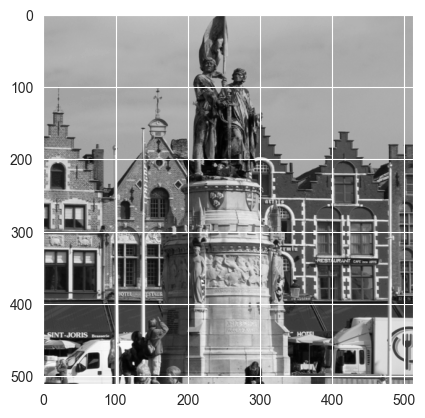

In [4]:
im = Image.open(f'{IMAGES_DIR}/Image00001.tif')
image = np.array(im)
plt.imshow(image, cmap='gray')

In [5]:
image.shape

(512, 512)

In [6]:
def generate_payload(N1, N2, q):
    Nb = int(N1 * N2 * q)
    return np.random.randint(0, 1 + 1, size=(Nb,), dtype=np.uint8)

In [7]:
def lsb_replacement(image_, bit_num, position_pairs, payload):
    image = image_.copy()
    for i, payload_bit in enumerate(payload):
        x, y = position_pairs[i]
        image[x, y] &= (255 ^ (1 << (bit_num - 1)))
        image[x, y] += payload_bit << (bit_num - 1)
    return image

In [8]:
def get_pseudorandom_coord_list(image_shape):
    np.random.seed(RANDOM_STATE)
    x_shape, y_shape = image_shape
    coordinate_pairs = np.stack(np.meshgrid(np.arange(x_shape), np.arange(y_shape)), axis=-1).reshape(-1, 2)
    return np.random.permutation(coordinate_pairs)

In [9]:
x_shape, y_shape = image.shape

In [10]:
noised_image = lsb_replacement(image, BINARY_NUM, get_pseudorandom_coord_list(image.shape), generate_payload(*image.shape, q = 0.8))

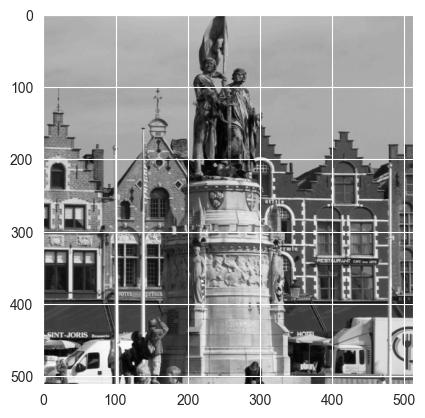

In [11]:
plt.imshow(noised_image, cmap='gray')  # Изображение с НЗБ-встраиванием

In [12]:
def get_binary_plane(image, plane_number):
    # plane number is indexing from 1

    return np.bitwise_and(image, 1 << (plane_number - 1)).astype(np.uint8)

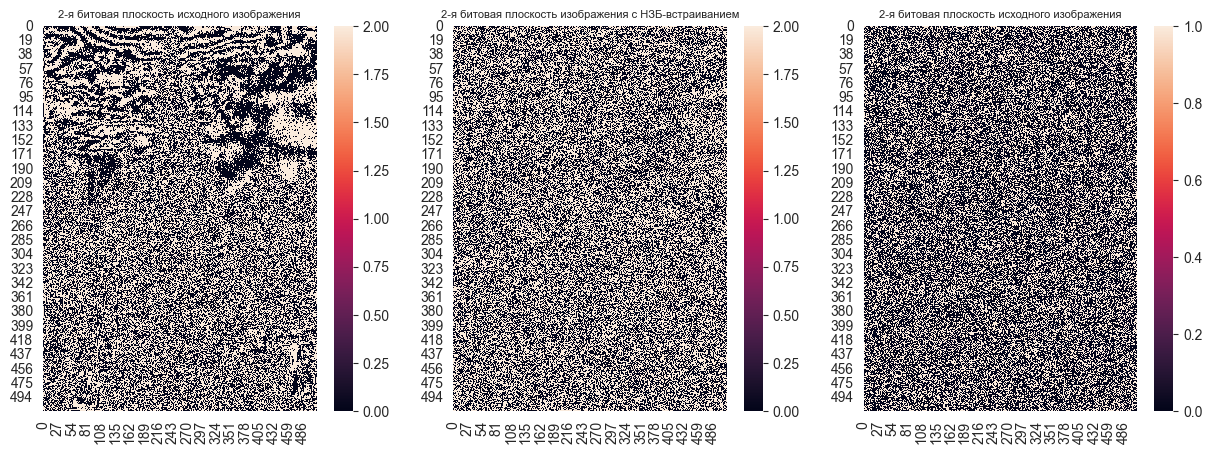

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(get_binary_plane(image, BINARY_NUM))
plt.title(f"{BINARY_NUM}-я битовая плоскость исходного изображения", fontsize=8)

plt.subplot(1, 3, 2)
sns.heatmap(get_binary_plane(noised_image, BINARY_NUM))
plt.title(f"{BINARY_NUM}-я битовая плоскость изображения с НЗБ-встраиванием", fontsize=8)

plt.subplot(1, 3, 3)
sns.heatmap(image != noised_image)
plt.title(f"{BINARY_NUM}-я битовая плоскость исходного изображения", fontsize=8)

plt.show()

## Создание набора данных

In [14]:
def get_hist_t(hist_e) -> np.ndarray:
    assert len(hist_e) % 2 == 0
    return np.array([(hist_e[2 * (i // 2)] + hist_e[2 * (i // 2) + 1]) / 2 for i in range(len(hist_e))])

In [15]:
def get_chi_components(hist_e, hist_t) -> np.ndarray:
    diffs_chi = (hist_e - hist_t) ** 2
    non_zero_mask = hist_t > 0
    diffs_chi[non_zero_mask] /= hist_t[non_zero_mask]
    return diffs_chi

In [16]:
def get_features(image):
    hist_e = np.histogram(image, bins=256, range=(0, 256))[0]
    hist_t = get_hist_t(hist_e)

    return get_chi_components(hist_e, hist_t)[::2]

In [17]:
def process_one_file(params):
    filename, need_noise, q, coord_seed = params
    im = Image.open(filename)
    image = np.array(im)

    if need_noise:
        image = lsb_replacement(image,
                                1,
                                get_pseudorandom_coord_list(image.shape),
                                generate_payload(*image.shape, q))

    features = get_features(image)

    return list(features) + [1 if need_noise else 0]

In [18]:
def prepare_dataset(all_files_list: list, q, no_noise_size=0.5, coord_seed=None) -> pd.DataFrame:
    need_noise_arr = np.zeros(shape=(len(all_files_list),), dtype=bool)
    need_noise_arr[int(len(all_files_list) * no_noise_size):] = True

    with Pool(processes=10) as p:
        rows = p.map(process_one_file, list(zip(all_files_list,
                                                list(need_noise_arr),
                                                [q] * len(all_files_list),
                                                [coord_seed] * len(all_files_list))))

    dataset = pd.DataFrame(columns=(list(map(str, range(len(rows[0]) - 1))) + ['noised']), data=rows)
    dataset = dataset.astype({'noised': int})
    return dataset

In [19]:
all_files = list(Path(IMAGES_DIR).glob('*.tif'))

Path(DATASETS_DIR).mkdir(parents=True, exist_ok=True)

for q in tqdm(Q):
    df = prepare_dataset(all_files, q=q)
    df.to_csv(f'{DATASETS_DIR}/data_{q}.csv', index=False)

100%|██████████| 9/9 [08:05<00:00, 53.95s/it]
